# Image Classification of Mouse Footfaults

## Load Dataset

In [51]:
import torch
import torchvision
import os
import pandas as pd

from PIL import Image
from pathlib import Path
from skimage.io import imread
from torch.utils.data import Dataset, DataLoader

In [49]:
def load_nina_v0():
    data_path = Path(os.environ['DATASETS_PATH']) / 'NINAv0'
    footfalls = list(data_path.glob('*/Normal*/[!._]*.png'))
    normal = list(data_path.glob('*/Footfault*/[!._]*.png'))
    images = footfalls + normal
    df = pd.DataFrame({"image": images})
    df["group"] = df.image.apply(lambda x: x.parts[-3])
    df["target"] = df.image.apply(lambda x: "Normal" not in x.parts[-2]).astype(int)
    return df

df = load_nina_v0()
df.groupby('target').count()

,image,group
target,,
0,1291,1291
1,22,22


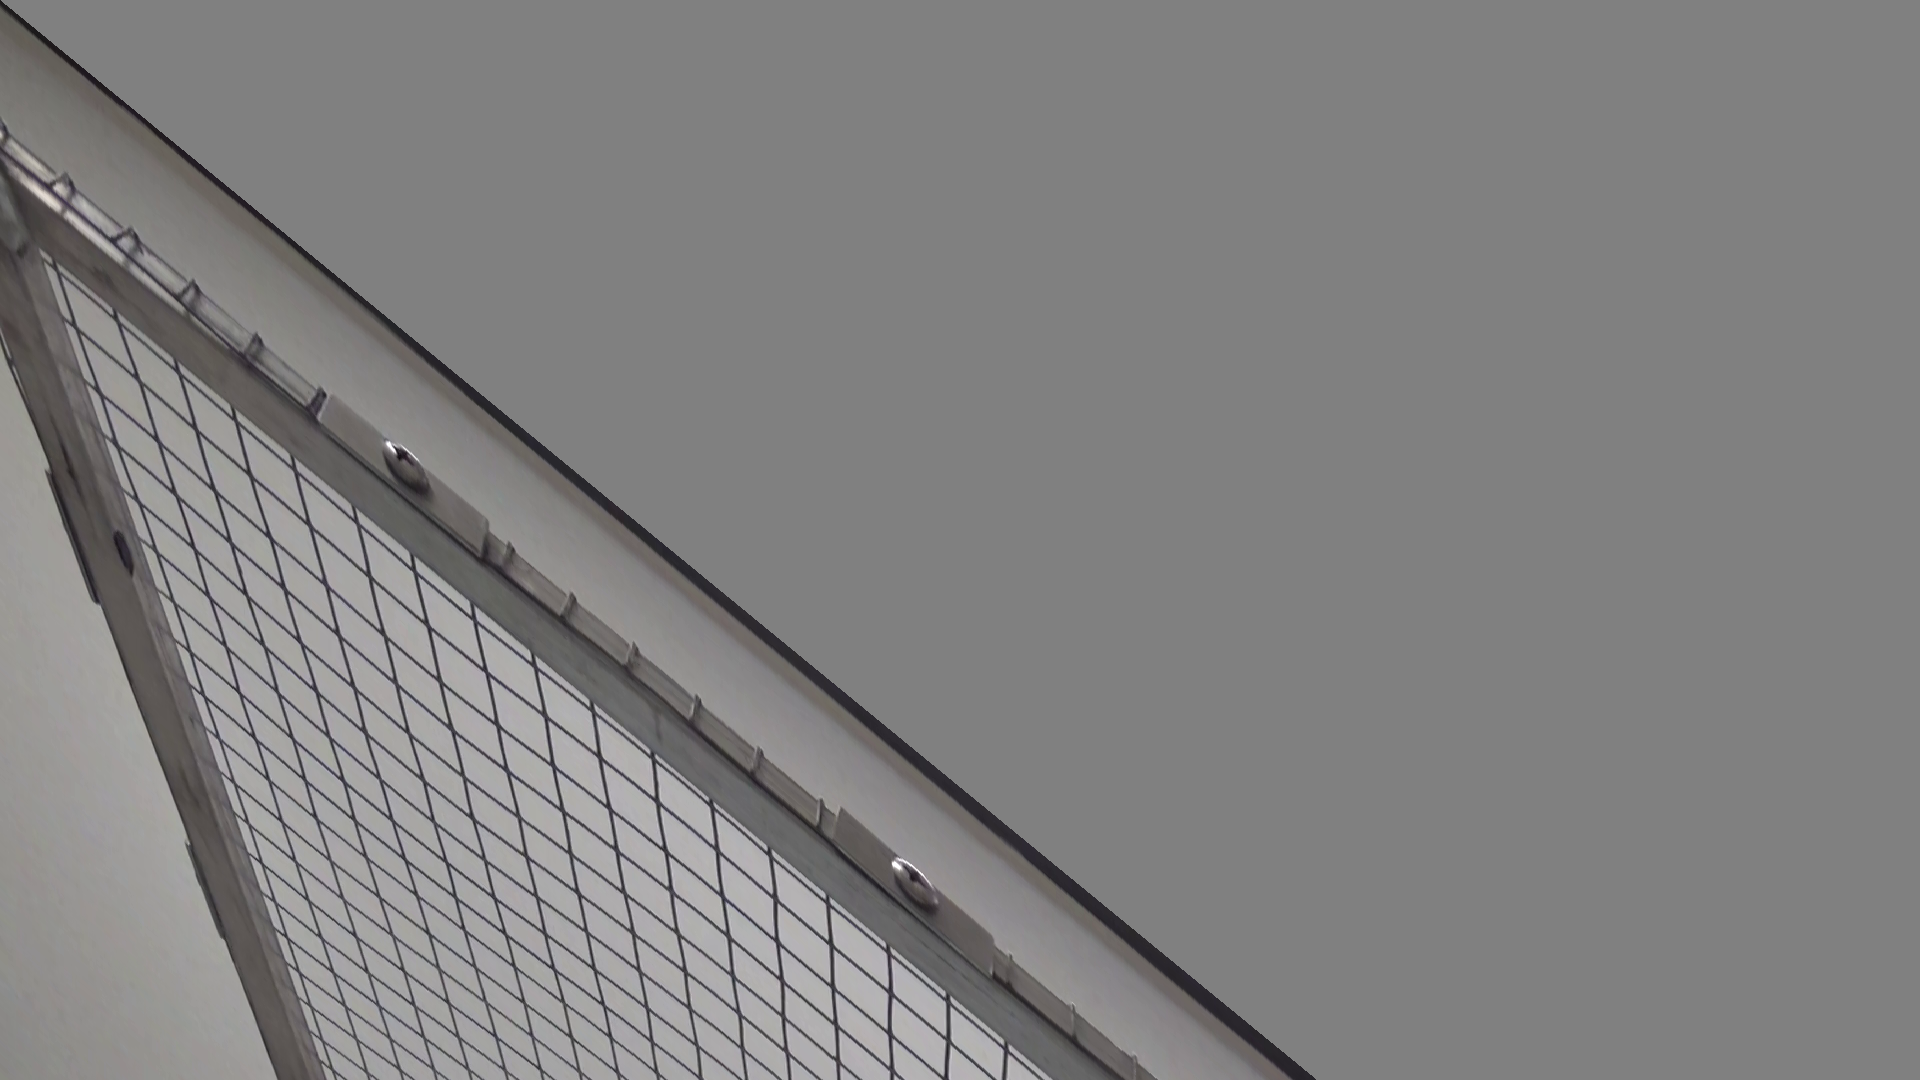

In [258]:
class FootfaultDataset(Dataset):
    def __init__(self, df, image_transform):
        super().__init__()
        self.df = df
        self.image_transform = image_transform

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        s = self.df.iloc[idx]
        image = self.image_transform(imread(s.image))
        return image, s.target

training_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    # torchvision.transforms.Resize((270, 480)), # 1920,1080 / 4
    torchvision.transforms.TrivialAugmentWide(num_magnitude_bins=100, fill=128),
    torchvision.transforms.ToTensor()
])

dataset = FootfaultDataset(df, training_transform)
image, target = dataset[0]
torchvision.transforms.ToPILImage()(image)

**Decision**: We have a very rare class, do we use weighted sampling or weighted loss?

With weighted loss and small batches, it's very likely no footfault images will appear in a batch. However, with weighted sampling, it's very likely to memorize the footfault images very quickly.

Better would be to better balances the classes with more weighted samples.



tensor(1)


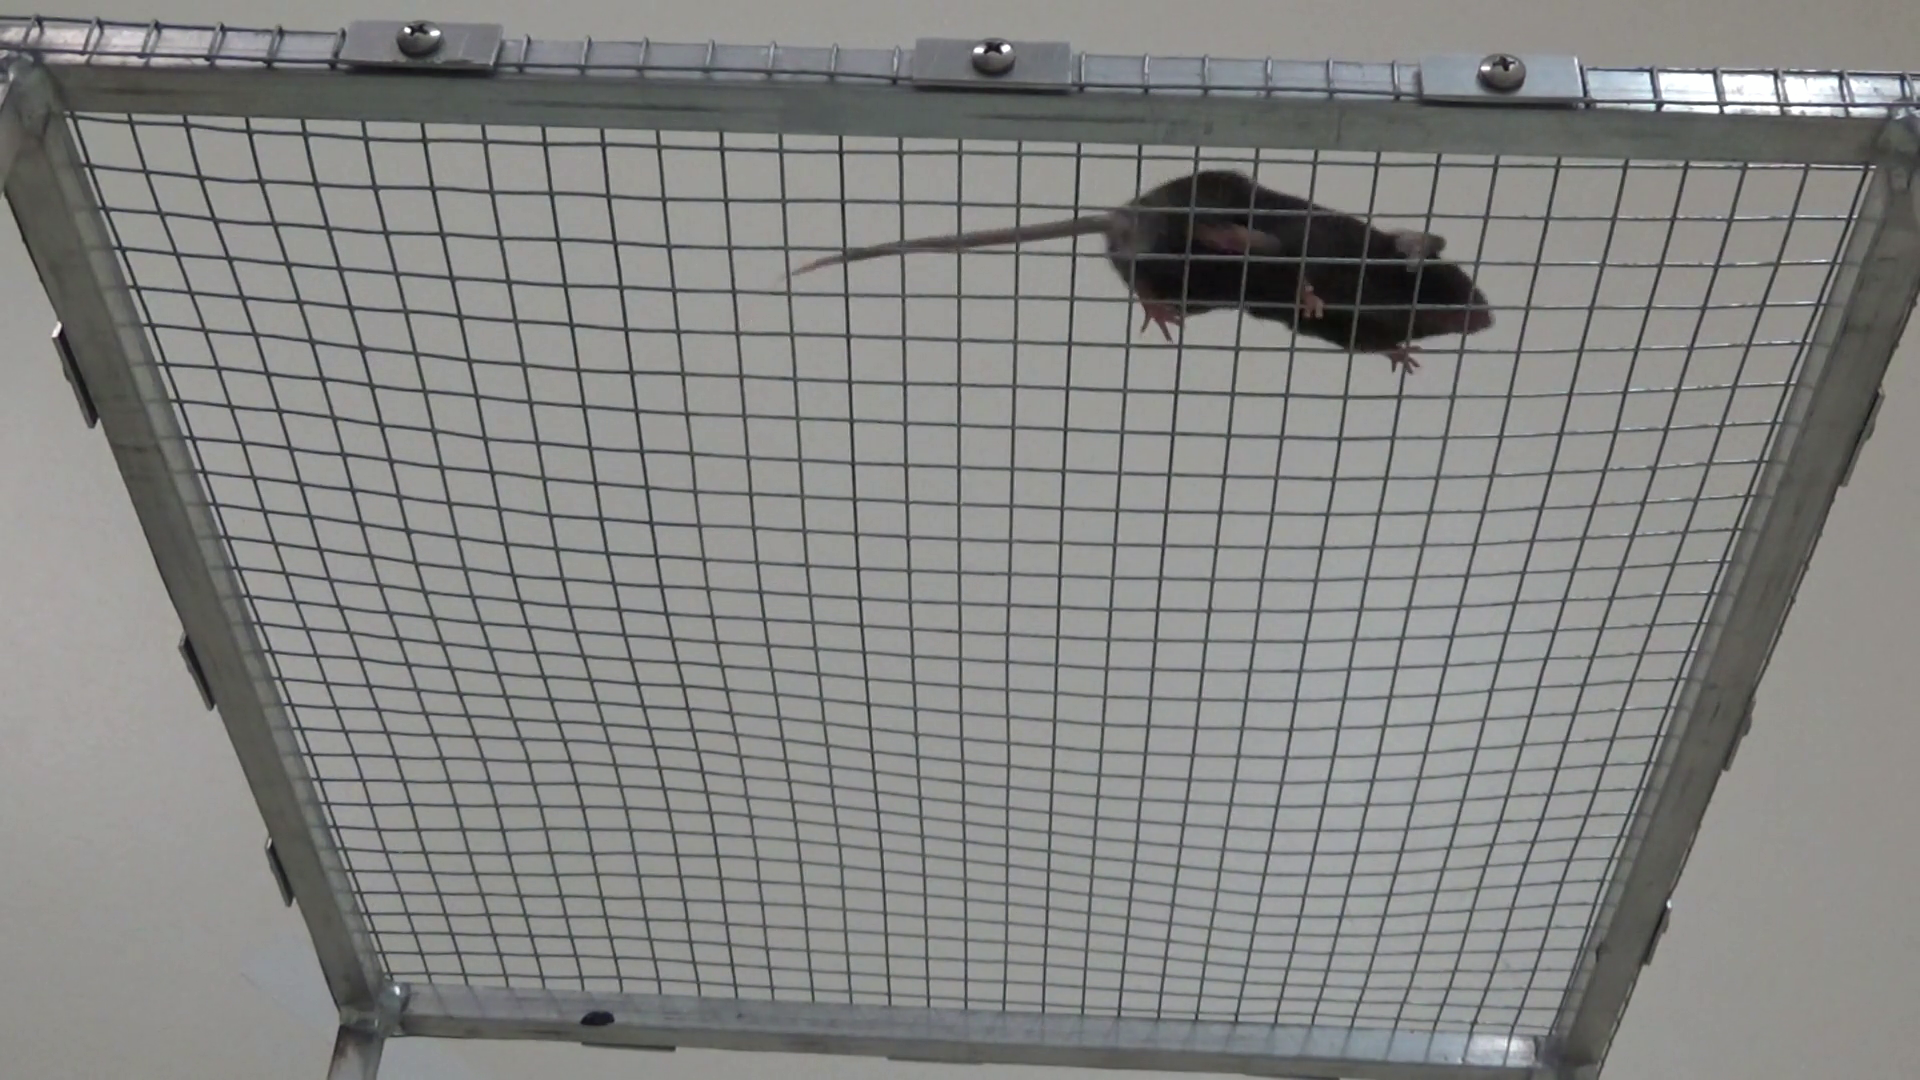

In [236]:
from torch.utils.data import WeightedRandomSampler
from sklearn.utils.class_weight import compute_class_weight

weights = compute_class_weight('balanced', classes=df.target, y=df.target)
sampler = WeightedRandomSampler(weights, len(weights), replacement=True)
dataloader = DataLoader(dataset, sampler=sampler)

for batch, targets in dataloader:
    break

print(targets[0])
torchvision.transforms.ToPILImage()(batch[0])

## Model

In [291]:
import pytorch_lightning as pl

from torchmetrics import ConfusionMatrix
from torchvision.models import ResNet34_Weights, resnet34
from torchvision.models import ResNet50_Weights, resnet50

class FootfaultModel(pl.LightningModule):
    def __init__(self, config):
        super().__init__()
        
        self._model = resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)
        # self._model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

        # Add a new model head with only 2 class predications
        in_features = self._model.fc.in_features
        self._model.fc = torch.nn.Linear(in_features, 2)

        # Standard classification loss
        self.criterion = torch.nn.CrossEntropyLoss()

        # Other hparams
        self.config = config

        # logs
        self.cm = ConfusionMatrix(2)

    def configure_optimizers(self):
        # SGD tends to generalize better than more advanced methods like Adam*
        optimizer = torch.optim.SGD(self.parameters(), self.config['learning_rate'], momentum=0.9)

        # Cosine annealing learning-rate scheduler + linear warmup
        scheduler = torch.optim.lr_scheduler.SequentialLR(
            optimizer,
            schedulers=[
                torch.optim.lr_scheduler.LinearLR(
                    optimizer, start_factor=self.config['warmup_decay'], total_iters=self.config['warmup_epochs']),
                torch.optim.lr_scheduler.CosineAnnealingLR(
                    optimizer, self.trainer.max_steps-self.config['warmup_epochs']),
            ], 
            milestones=[self.config['warmup_epochs']]
        )

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
            }
        }

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self._model(x)
        loss = self.criterion(y_hat, y)
        self.log("train_loss", loss)

        tp, fn, fp, tn = self.cm(y_hat, y).cpu().numpy().reshape(-1)
        self.log("train_tp", tp, prog_bar=True)
        self.log("train_tn", tn, prog_bar=True)
        self.log("train_fp", fp, prog_bar=True)
        self.log("train_fn", fn, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self._model(x)
        loss = self.criterion(y_hat, y)
        self.log("val_loss", loss)
        tp, fn, fp, tn = self.cm(y_hat, y).cpu().numpy().reshape(-1)
        self.log("val_tp", tp)
        self.log("val_tn", tn)
        self.log("val_fp", fp)
        self.log("val_fn", fn)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self._model(x)
        loss = self.criterion(y_hat, y)
        self.log("test_loss", loss)
        tp, fn, fp, tn = self.cm(y_hat, y).cpu().numpy().reshape(-1)
        self.log("test_tp", tp)
        self.log("test_tn", tn)
        self.log("test_fp", fp)
        self.log("test_fn", fn)
        return loss


## Training Loop

In [292]:
from sklearn.model_selection import GroupKFold

config = dict(
    batch_size=1,
    learning_rate=1e-3,
    warmup_decay=1e-4,
    warmup_epochs=1,
    max_epochs=5
)

# train/testing augmentation
training_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.TrivialAugmentWide(num_magnitude_bins=100, fill=128),
    torchvision.transforms.ToTensor()
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

# CV split by group
cv = GroupKFold(10)
for train, test in cv.split(df.index, groups=df.group):
    train_df = df.loc[df.index[train]]
    test_df = df.loc[df.index[test]]

    # Create datasets
    train_dataset = FootfaultDataset(train_df, training_transform)
    test_dataset = FootfaultDataset(test_df, test_transform)

    # Dataloader
    train_weights = compute_class_weight('balanced', classes=train_df.target, y=train_df.target)
    train_sampler = WeightedRandomSampler(train_weights, len(train_weights), replacement=True)
    train_dataloader = DataLoader(train_dataset, batch_size=config['batch_size'], sampler=train_sampler)

    test_dataloader = DataLoader(test_dataset, batch_size=config['batch_size'])

    # Initialize model
    model = FootfaultModel(config)
    
    # Train 
    print("New Fold, test group", test_df.group.unique())

    trainer = pl.Trainer(
        max_epochs=config['max_epochs'],
        accelerator='gpu', devices=[0],
        enable_checkpointing=False,
    )

    trainer.fit(model, train_dataloader, test_dataloader)
    trainer.test(model, test_dataloader)

New Fold, test group ['2213-D7' '2213-D0']


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | _model    | ResNet           | 21.3 M
1 | criterion | CrossEntropyLoss | 0     
2 | cm        | ConfusionMatrix  | 0     
-----------------------------------------------
21.3 M    Trainable params
0         Non-trainable params
21.3 M    Total params
85.143    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:657: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Testing: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:234: UserWarning: You called `self.log('test_tp', ...)` in your `test_step` but the value needs to be floating point. Converting it to torch.float32.
  f"You called `self.log({self.meta.name!r}, ...)` in your `{self.meta.fx}` but the value needs to"
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:234: UserWarning: You called `self.log('test_tn', ...)` in your `test_step` but the value needs to be floating point. Converting it to torch.float32.
  f"You called `self.log({self.meta.name!r}, ...)` in your `{self.meta.fx}` but the value needs to"
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:234: UserWarning: You called `self.log('test_fp', ...)` in your `test_step` but the value needs to be floating point. Converting it to torch.float32.
  f"You called `self.log({self.meta.name!

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         test_fn           0.005586592014878988
         test_fp           0.011173184029757977
        test_loss           0.43840286135673523
         test_tn                    0.0
         test_tp            0.9832402467727661
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
New Fold, test group ['2211-D0' '2212-D14']


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | _model    | ResNet           | 21.3 M
1 | criterion | CrossEntropyLoss | 0     
2 | cm        | ConfusionMatrix  | 0     
-----------------------------------------------
21.3 M    Trainable params
0         Non-trainable params
21.3 M    Total params
85.143    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]